# Statement

## Goal:
---
The telecom operator Interconnect would like to be able to forecast their churn of clients.

### Key Question:
What factors or features will predict or determine customer churn?

### Stages:
- Task 1: Feature Engineering: Look into how each feature's relationship is to the target variable and apply neccessary transformations to capture those relationship
- Task 2: Handle Class Imbalance
- Task 3: Scale Features in Dataset
- Task 4: Train Various Classification models
- Task 5: Interpret Model Results/Select highest AUC-ROC score
- Task 6: Develop Conclusions based on insights


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import shap
from scipy.stats import randint, uniform

In [ ]:
contracts_df = pd.read_csv("/datasets/contract.csv") # file holds contract information
internet_df = pd.read_csv("/datasets/internet.csv") # file holds the client's personal information
personal_df = pd.read_csv("/datasets/personal.csv") # file holds the Internet services information
phone_df = pd.read_csv("/datasets/phone.csv") # file holds telephone services information

Note: In each file, the column 'customerID' contains a unique code assigned to each client.

## Data Preparation
-------

### 1) Data Inspection

In [ ]:
def data_inspection(df):
    print("\nFirst 5 Rows:")
    display(df.head())
    print(f"# of Duplicates: {df.duplicated().sum()}")
    print("\nData types and non-null counts:")
    print(df.info())
    print(f"Shape: {df.shape}")

In [ ]:
print('Contracts:')
print('-----------------')
display(data_inspection(contracts_df))

Contracts:
-----------------

First 5 Rows:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


# of Duplicates: 0

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Shape: (7043, 8)


None

In [ ]:
print('Internet:')
print('-----------------')
data_inspection(internet_df)

Internet:
-----------------

First 5 Rows:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


# of Duplicates: 0

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
Shape: (5517, 8)


In [ ]:
print('Phone:')
print('-----------------')
data_inspection(personal_df)

Phone:
-----------------

First 5 Rows:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


# of Duplicates: 0

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Shape: (7043, 5)


In [ ]:
print('Personal:')
print('-----------------')
data_inspection(phone_df)

Personal:
-----------------

First 5 Rows:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


# of Duplicates: 0

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Shape: (6361, 2)


After doing an inspection of all four dataset, there appears to be no null values or duplicates present. However, to follow proper naming convention, the headings need to be lowercase.

In [ ]:
contracts_df = contracts_df.rename(columns=lambda x: x.lower()) # Convert column names to lowercase
internet_df = internet_df.rename(columns=lambda x: x.lower())
personal_df = personal_df.rename(columns=lambda x: x.lower())
phone_df = phone_df.rename(columns=lambda x: x.lower())

In [ ]:
print(f'Contracts Dataframe Column Names: {contracts_df.columns}')
print('')
print(f'Internet Dataframe Column Names: {internet_df.columns}')
print(' ')
print(f'Personal Dataframe Column Names: {personal_df.columns}')
print(' ')
print(f'Phone Dataframe Column Names: {phone_df.columns}')

Contracts Dataframe Column Names: Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

Internet Dataframe Column Names: Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')
 
Personal Dataframe Column Names: Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')
 
Phone Dataframe Column Names: Index(['customerid', 'multiplelines'], dtype='object')


On a structural standpoint, everything seems good to go and the focus can be set on the explanatory data analysis.

### 2) Data Cleaning/Preparing Data for Analysis

Since a ML model will be used in subsequent analysis, all of the variables within this and the other dataframes need to be in a numerical format via OHE for some models, while some models like LightGBM or CatBoost doesn't require this.

- contracts_df: type, paperlessbilling, payment method
- internet_df: internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies
- personal_df: gender, partner, dependents
- phone_df: multiplelines

* 'customerid' will not be included in the final combined dataset due to the fact that customerid doesn't have an impact on whether a customer churns a service. However, this column will be used in concatenating the dataframes appropriately.

After merging all of the datasets into one. Let's explore and uncover any insights within it.

In [ ]:
mass_df = personal_df.merge(internet_df, on='customerid', how='outer')
mass_df = mass_df.merge(phone_df, on='customerid', how='outer')
mass_df = mass_df.merge(contracts_df, on='customerid', how='outer')

In [ ]:
mass_df

,customerid,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [ ]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   internetservice   5517 non-null   object 
 6   onlinesecurity    5517 non-null   object 
 7   onlinebackup      5517 non-null   object 
 8   deviceprotection  5517 non-null   object 
 9   techsupport       5517 non-null   object 
 10  streamingtv       5517 non-null   object 
 11  streamingmovies   5517 non-null   object 
 12  multiplelines     6361 non-null   object 
 13  begindate         7043 non-null   object 
 14  enddate           7043 non-null   object 
 15  type              7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [ ]:
mass_df['customerid'].duplicated().sum()  # Count of duplicate rows

0

In [ ]:
mass_df = mass_df.drop(columns=['customerid'])  # Drop specific columns

In [ ]:
mass_df.head()

,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


After merging the various dataframes, some null values presented themselves. Instead of dropping them, to maintain the quantity of the data, the null values present within categorical columns will be filled with the mode and for numerical columns, the median.

In [ ]:
def fill_nulls(df, column):
  df[column] = df[column].fillna(value=df[column].mode()[0])  # Fill missing values


In [ ]:
fill_nulls(mass_df, 'internetservice')
fill_nulls(mass_df, 'onlinesecurity')
fill_nulls(mass_df, 'onlinebackup')
fill_nulls(mass_df, 'deviceprotection')
fill_nulls(mass_df, 'techsupport')
fill_nulls(mass_df, 'streamingtv')
fill_nulls(mass_df, 'streamingmovies')
fill_nulls(mass_df, 'multiplelines')

In [ ]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   internetservice   7043 non-null   object 
 5   onlinesecurity    7043 non-null   object 
 6   onlinebackup      7043 non-null   object 
 7   deviceprotection  7043 non-null   object 
 8   techsupport       7043 non-null   object 
 9   streamingtv       7043 non-null   object 
 10  streamingmovies   7043 non-null   object 
 11  multiplelines     7043 non-null   object 
 12  begindate         7043 non-null   object 
 13  enddate           7043 non-null   object 
 14  type              7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


Taking a quick look at each columns data type, most columns seem to hold categorical data, such as 'internetservice' and 'gender. While some contain numerical data, like 'monthlycharges' and 'totalcharges'.

In [ ]:
cat_columns = ['type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup',
'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'gender', 'partner', 'dependents', 'multiplelines']


mass_df_encoded = pd.get_dummies(mass_df, columns=cat_columns, dtype=int, drop_first=True)

In [ ]:
mass_df_encoded.head()

,seniorcitizen,begindate,enddate,monthlycharges,totalcharges,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,gender_Male,partner_Yes,dependents_Yes,multiplelines_Yes
0,0,2020-01-01,No,29.85,29.85,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0,2017-04-01,No,56.95,1889.5,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,2019-10-01,2019-12-01 00:00:00,53.85,108.15,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
3,0,2016-05-01,No,42.30,1840.75,1,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0
4,0,2019-09-01,2019-11-01 00:00:00,70.70,151.65,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mass_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   seniorcitizen                          7043 non-null   int64  
 1   begindate                              7043 non-null   object 
 2   enddate                                7043 non-null   object 
 3   monthlycharges                         7043 non-null   float64
 4   totalcharges                           7043 non-null   object 
 5   type_One year                          7043 non-null   int64  
 6   type_Two year                          7043 non-null   int64  
 7   paperlessbilling_Yes                   7043 non-null   int64  
 8   paymentmethod_Credit card (automatic)  7043 non-null   int64  
 9   paymentmethod_Electronic check         7043 non-null   int64  
 10  paymentmethod_Mailed check             7043 non-null   int64  
 11  inte

In [ ]:
#mass_df_encoded['totalcharges'] = pd.to_numeric(mass_df_encoded['totalcharges'],errors='raise')
""" after trying to convert the 'totalcharges' column to numeric, it was found that there are some non-numeric values in the column."
These non-numeric values need to be handled before conversion. To handle this, we will first replace any non-numeric values with "
NaN and then convert the column to numeric."""
mass_df_encoded['totalcharges'] = pd.to_numeric(mass_df_encoded['totalcharges'], errors='coerce')
mass_df_encoded['totalcharges']= mass_df_encoded['totalcharges'].astype(float)  # Convert to float
mass_df['totalcharges'] = pd.to_numeric(mass_df['totalcharges'], errors='coerce')
mass_df['totalcharges']= mass_df['totalcharges'].astype(float)  # Convert to float

In [ ]:
mass_df_encoded.info()
mass_df.info()

# Drop rows with NaN values in 'totalcharges'
mass_df_encoded = mass_df_encoded.dropna()
mass_df = mass_df.dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   seniorcitizen                          7043 non-null   int64  
 1   begindate                              7043 non-null   object 
 2   enddate                                7043 non-null   object 
 3   monthlycharges                         7043 non-null   float64
 4   totalcharges                           7032 non-null   float64
 5   type_One year                          7043 non-null   int64  
 6   type_Two year                          7043 non-null   int64  
 7   paperlessbilling_Yes                   7043 non-null   int64  
 8   paymentmethod_Credit card (automatic)  7043 non-null   int64  
 9   paymentmethod_Electronic check         7043 non-null   int64  
 10  paymentmethod_Mailed check             7043 non-null   int64  
 11  inte

Looking at the target variable, 'enddate', there should be two classes: one class for 'no' and another for all of the churn dates. To effectively input this into a model, the target needs to be two classes, in this case it is appropriate for those classes to be 'yes' and 'no'.

The date a customer canceled their plan isn't the target we are trying to predict. However, the main focus is trying to predict whether a customer will cancel or not.

The end dates are valuable in calculating the length of service which could then be used as a feature in calculating the target.

In [ ]:
mass_df_encoded.head()

,seniorcitizen,begindate,enddate,monthlycharges,totalcharges,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,gender_Male,partner_Yes,dependents_Yes,multiplelines_Yes
0,0,2020-01-01,No,29.85,29.85,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0,2017-04-01,No,56.95,1889.50,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,2019-10-01,2019-12-01 00:00:00,53.85,108.15,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
3,0,2016-05-01,No,42.30,1840.75,1,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0
4,0,2019-09-01,2019-11-01 00:00:00,70.70,151.65,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
old_value = ['2019-11-01 00:00:00', '2019-10-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00']
new_value = 'Yes'
mass_df_encoded['enddate'] = mass_df_encoded['enddate'].replace(old_value, new_value) # Replaces old values with new values
mass_df['enddate'] = mass_df['enddate'].replace(old_value, new_value) # Replaces old values with new values

In [ ]:
print(mass_df_encoded['enddate'].value_counts())  # Check the value counts of 'enddate' column
print(mass_df['enddate'].value_counts())

No     5163
Yes    1869
Name: enddate, dtype: int64
No     5163
Yes    1869
Name: enddate, dtype: int64


In order to create a new feature that captures the qualities of the 'begin date' feature of a customer has, the respective column will be taken apart and each data attribute (month, year) will have its own year.

In [ ]:
mass_df_encoded['begindate'] = pd.to_datetime(mass_df_encoded['begindate']) # Convert 'begindate' column to datetime
mass_df['begindate'] = pd.to_datetime(mass_df['begindate']) # Convert 'begindate' column to datetime

In [ ]:
mass_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   seniorcitizen                          7032 non-null   int64         
 1   begindate                              7032 non-null   datetime64[ns]
 2   enddate                                7032 non-null   object        
 3   monthlycharges                         7032 non-null   float64       
 4   totalcharges                           7032 non-null   float64       
 5   type_One year                          7032 non-null   int64         
 6   type_Two year                          7032 non-null   int64         
 7   paperlessbilling_Yes                   7032 non-null   int64         
 8   paymentmethod_Credit card (automatic)  7032 non-null   int64         
 9   paymentmethod_Electronic check         7032 non-null   int64   

In [ ]:
mass_df_encoded['beginmonth'] = mass_df_encoded['begindate'].dt.month # Extract month from 'begindate' column
mass_df_encoded['beginyear'] = mass_df_encoded['begindate'].dt.year # Extract year from 'begindate' column
mass_df['beginmonth'] = mass_df['begindate'].dt.month # Extract month from 'begindate' column
mass_df['beginyear'] = mass_df['begindate'].dt.year # Extract year from 'begindate' column

In [ ]:
mass_df_encoded.head()

,seniorcitizen,begindate,enddate,monthlycharges,totalcharges,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,gender_Male,partner_Yes,dependents_Yes,multiplelines_Yes,beginmonth,beginyear
0,0,2020-01-01,No,29.85,29.85,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,2020
1,0,2017-04-01,No,56.95,1889.50,1,0,0,0,0,...,1,0,0,0,1,0,0,0,4,2017
2,0,2019-10-01,Yes,53.85,108.15,0,0,1,0,0,...,0,0,0,0,1,0,0,0,10,2019
3,0,2016-05-01,No,42.30,1840.75,1,0,0,0,0,...,1,1,0,0,1,0,0,0,5,2016
4,0,2019-09-01,Yes,70.70,151.65,0,0,1,0,1,...,0,0,0,0,0,0,0,0,9,2019


In [ ]:
mass_df_encoded = mass_df_encoded.drop(columns=['begindate'])  # Drop original 'begindate' column
mass_df_encoded['enddate'] = pd.get_dummies(mass_df_encoded['enddate'], dtype=int, drop_first=True) # Convert 'enddate' column to binary values

mass_df = mass_df.drop(columns=['begindate'])  # Drop original 'begindate' column
mass_df['enddate'] = pd.get_dummies(mass_df['enddate'], dtype=int, drop_first=True) # Convert 'enddate' column to binary values

In [ ]:
mass_df_encoded.head()

,seniorcitizen,enddate,monthlycharges,totalcharges,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,gender_Male,partner_Yes,dependents_Yes,multiplelines_Yes,beginmonth,beginyear
0,0,0,29.85,29.85,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,2020
1,0,0,56.95,1889.50,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,4,2017
2,0,1,53.85,108.15,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,10,2019
3,0,0,42.30,1840.75,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,5,2016
4,0,1,70.70,151.65,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,9,2019


In [ ]:
mass_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   seniorcitizen                          7032 non-null   int64  
 1   enddate                                7032 non-null   int64  
 2   monthlycharges                         7032 non-null   float64
 3   totalcharges                           7032 non-null   float64
 4   type_One year                          7032 non-null   int64  
 5   type_Two year                          7032 non-null   int64  
 6   paperlessbilling_Yes                   7032 non-null   int64  
 7   paymentmethod_Credit card (automatic)  7032 non-null   int64  
 8   paymentmethod_Electronic check         7032 non-null   int64  
 9   paymentmethod_Mailed check             7032 non-null   int64  
 10  internetservice_Fiber optic            7032 non-null   int64  
 11  onli

## Exploratory Data Analysis
---

In [ ]:
mass_df_encoded.describe()

,seniorcitizen,enddate,monthlycharges,totalcharges,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,gender_Male,partner_Yes,dependents_Yes,multiplelines_Yes,beginmonth,beginyear
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.00000
mean,0.162400,0.265785,64.798208,2283.300441,0.209329,0.239619,0.592719,0.216297,0.336320,0.228100,...,0.343857,0.290102,0.384386,0.388367,0.504693,0.482509,0.298493,0.421928,6.428185,2016.87372
std,0.368844,0.441782,30.085974,2266.771362,0.406858,0.426881,0.491363,0.411748,0.472483,0.419637,...,0.475028,0.453842,0.486484,0.487414,0.500014,0.499729,0.457629,0.493902,3.576972,1.96824
min,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.00000
25%,0.000000,0.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2015.00000
50%,0.000000,0.000000,70.350000,1397.475000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.000000,2017.00000
75%,0.000000,1.000000,89.862500,3794.737500,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,2019.00000
max,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,2020.00000


In [ ]:
corr_matrix = mass_df_encoded.corr()

In [ ]:
corr_matrix

,seniorcitizen,enddate,monthlycharges,totalcharges,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,gender_Male,partner_Yes,dependents_Yes,multiplelines_Yes,beginmonth,beginyear
seniorcitizen,1.000000,0.150541,0.219874,0.102411,-0.046491,-0.116205,0.156258,-0.024359,0.171322,-0.152987,...,0.059514,-0.060577,0.105445,0.119842,-0.001819,0.016957,-0.210550,0.142996,0.028569,-0.027386
enddate,0.150541,1.000000,0.192858,-0.199484,-0.178225,-0.301552,0.191454,-0.134687,0.301455,-0.090773,...,-0.066193,-0.164716,0.063254,0.060860,-0.008545,-0.149982,-0.163128,0.040033,0.180522,0.293770
monthlycharges,0.219874,0.192858,1.000000,0.651065,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568,...,0.482607,0.338301,0.629668,0.627235,-0.013779,0.097825,-0.112343,0.490912,-0.019613,-0.263086
totalcharges,0.102411,-0.199484,0.651065,1.000000,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708,...,0.522881,0.432868,0.515709,0.519867,0.000048,0.319072,0.064653,0.469042,-0.196624,-0.819304
type_One year,-0.046491,-0.178225,0.004810,0.170569,1.000000,-0.288843,-0.052278,0.067590,-0.109546,0.000197,...,0.102911,0.096258,0.061930,0.064780,0.007755,0.083067,0.069222,-0.003594,0.001926,-0.202671
type_Two year,-0.116205,-0.301552,-0.073256,0.358036,-0.288843,1.000000,-0.146281,0.174410,-0.281147,-0.007423,...,0.165248,0.240924,0.072124,0.075603,-0.003603,0.247334,0.201699,0.106618,-0.193974,-0.542400
paperlessbilling_Yes,0.156258,0.191454,0.351930,0.157830,-0.052278,-0.146281,1.000000,-0.013726,0.208427,-0.203981,...,0.104079,0.037536,0.224241,0.211583,-0.011902,-0.013957,-0.110131,0.163746,0.022846,-0.017451
paymentmethod_Credit card (automatic),-0.024359,-0.134687,0.030055,0.182663,0.067590,0.174410,-0.013726,1.000000,-0.373978,-0.285583,...,0.111252,0.117024,0.040010,0.048398,0.001632,0.082327,0.061134,0.060319,-0.066562,-0.225678
paymentmethod_Electronic check,0.171322,0.301455,0.271117,-0.060436,-0.109546,-0.281147,0.208427,-0.373978,1.000000,-0.386971,...,-0.003308,-0.114807,0.144747,0.137420,0.000844,-0.083207,-0.149274,0.083583,0.077788,0.192956
paymentmethod_Mailed check,-0.152987,-0.090773,-0.376568,-0.294708,0.000197,-0.007423,-0.203981,-0.285583,-0.386971,1.000000,...,-0.187325,-0.084631,-0.247712,-0.250290,0.013199,-0.096948,0.056448,-0.227672,0.050142,0.238074


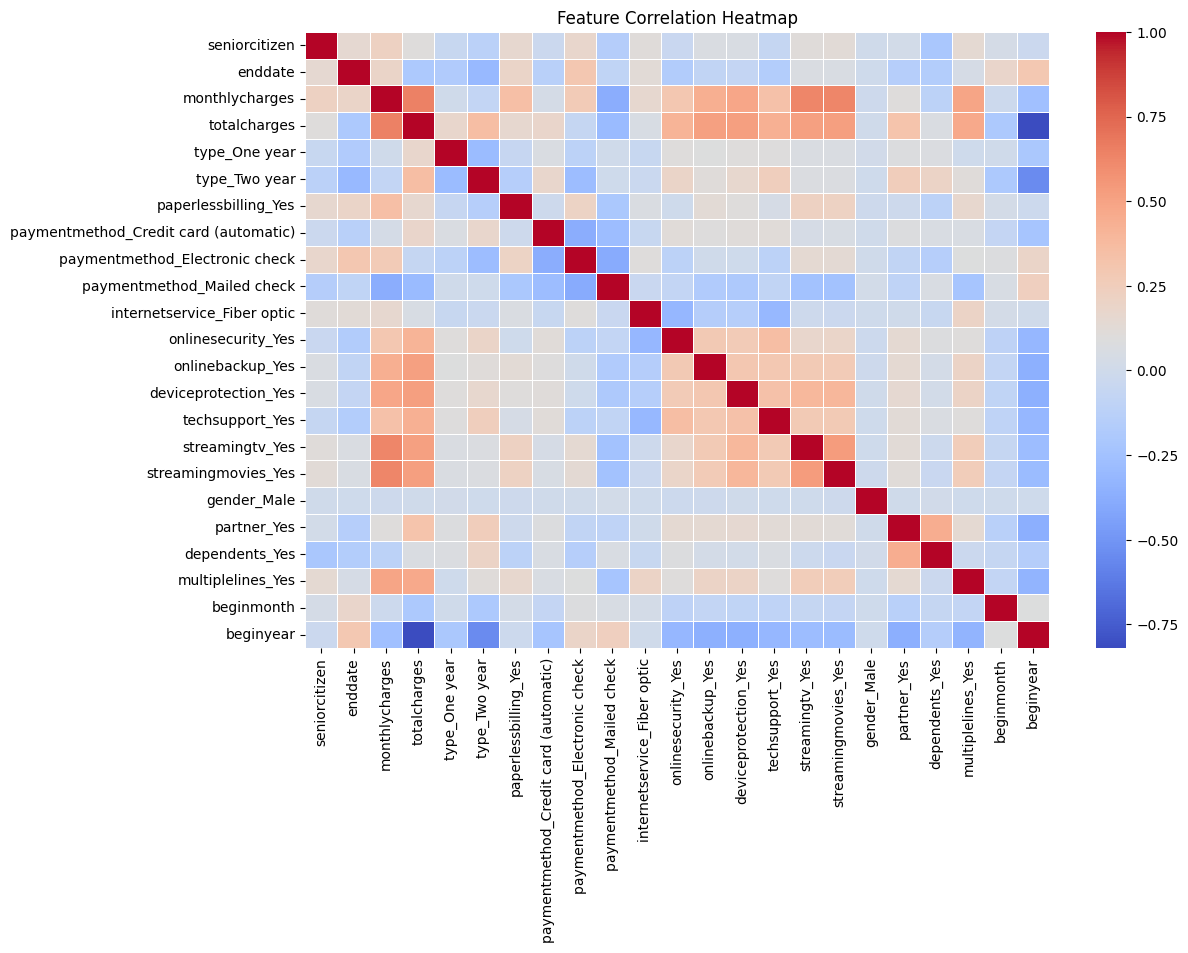

In [ ]:
# Plot a correlation heatmap to visualize the numerical representation of the correlation matrices
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Looking at this heatmap of the correlation between the variables, there seems to be a significant negative correlation between 'beginyear' and 'totalcharges'. This may indicate that as the total charges of ones phone service increases, this indicates a later/earlier/smaller begin date.

Note: Keeping this end mind when it's time for model training as this may influence results.

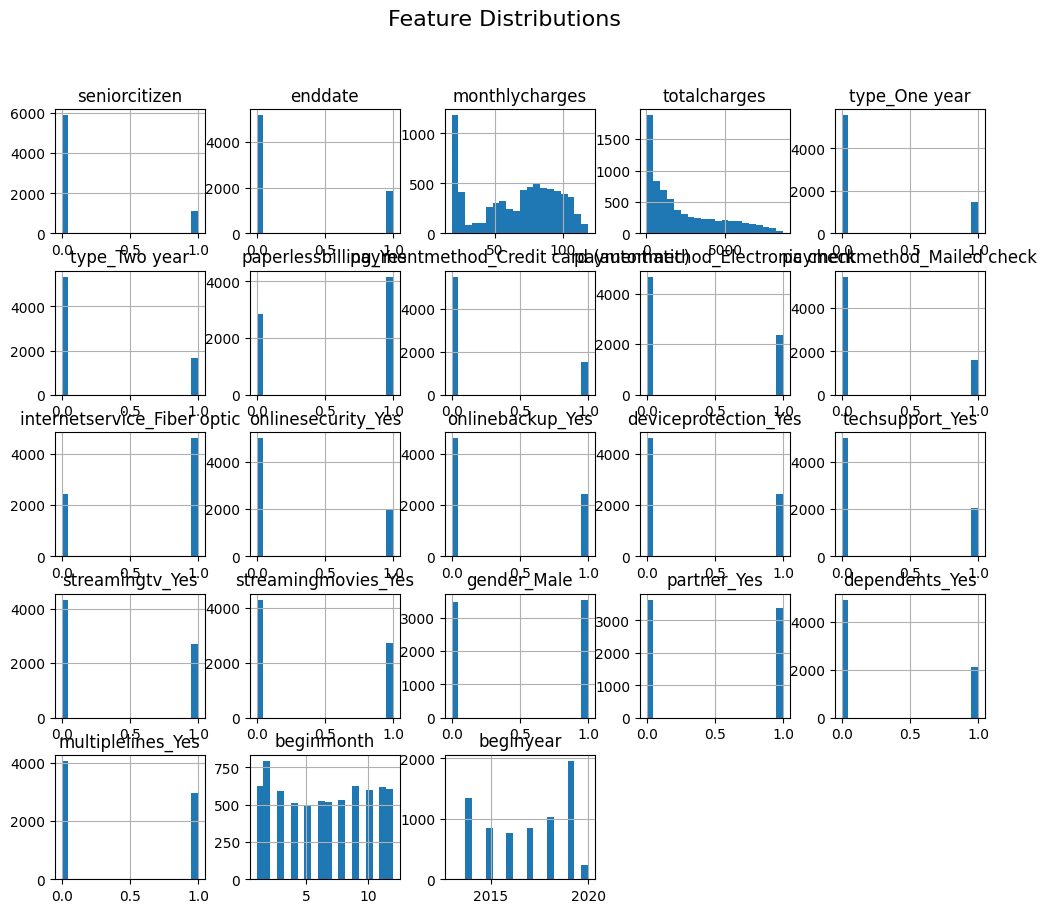

In [ ]:
# Plot histograms for selected features
mass_df_encoded.hist(figsize=(12, 10), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

Looking at the distributions for the variables 'monthlycharges', 'totalcharges', and servicelength, the distribution for 'totalcharges' is right skewed (mean > median), the distirbution of 'monthlycharges' is slightly left skewed (median > mean). As for the columns that have discrete values, there seems to be fair share of symetric and asymetric share of classes.

This really means that within the dataset more individuals/customers pay higher total charges than those with lower total charges. However for monthly charges, slightly more customers are paying lower amounts than others (this seems to be very marginal).

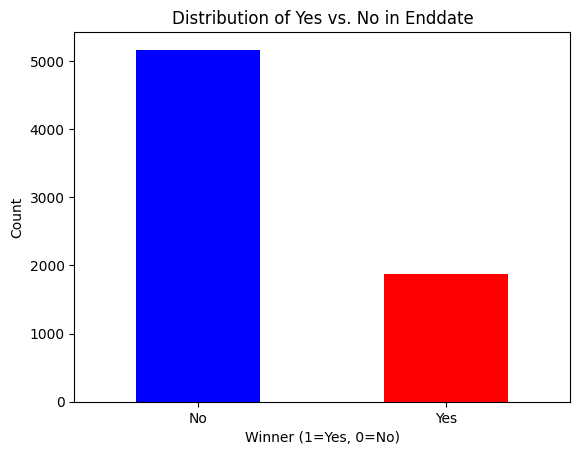

In [ ]:
# Plot target variable distribution
mass_df_encoded['enddate'].value_counts().plot(kind='bar', color=['blue', 'red'])

plt.title("Distribution of Yes vs. No in Enddate")
plt.xlabel("Winner (1=Yes, 0=No)")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0)
plt.show()

Zoning in on the target variable, 'enddate', there appears to be an apparent class imbalance with the 'yes' class have a larger share than the 'no' class.

A list of clarifying questions
A rough plan for solving the task, specifying 3-5 basic steps and explaining each step in one or two sentences

After doing exploratory data analysis, some clarifying questions made are:

1. On average, what time (# months) do customers decide to cancel their plans?
    1a. Do they tend to cancel during a certain time of the year?
2. How does plan terms (1 year, month-to-month, 2 year) factor into a customer deciding to cancel?
    2a. What are some reasons, other than income level, that make customers choose one plan over another?
3. Does a customer tend to not to cancel if they have more services; does access to more service lead to a customer not canceling?


Plan:

1. Feature Engineering: Look into how each feature's relationship is to the target variable and apply neccessary transformations to capture those relationship
2. Handle Class Imbalance
3. Scale Features in Dataset
4. Train Various Classification models
5. Interpret Model Results
6. Develop Conclusions based on insights
